# Portugal

This notebook contains all the Julia 1.4 code required to
characterize the propagation of CoViD19 as discussed in the main
notebook: _Population_dynamics.ipynb_

### Initialization, display LOAD_PATH at the end

In [1]:
push!(LOAD_PATH, pwd())
if ispath( pwd()*"/src")
    push!(LOAD_PATH, pwd()*"/src")
end


using SpecialFunctions, LaTeXStrings
using DataFrames, Query, CSV, Dates
using LsqFit

using MyFunctions, Mrate

using Plots
theme(:solarized_light)

### Parametrization for the incubation times, source:
https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000062

In [2]:
μΓ, σΓ = 6.5, 2.6       # mean and standard deviation for incubation

αΓ( μ, σ ) = μ^2/σ^2    # [α] = 1  is a dimensionless parameter
βΓ( μ, σ ) = μ / σ^2    # [β] = 1/T has dimension of frequency

α0 = αΓ( μΓ, σΓ )
β0 = βΓ( μΓ, σΓ )

ρ0=[α0,β0]

2-element Array{Float64,1}:
 6.249999999999999
 0.9615384615384615

### load data and manipulate data

In [3]:
dset_origin = "/data.europa.eu"
dset_name = "6u83xREK"
worlddata = CSV.File( pwd()*dset_origin*"/"*dset_name ) |> DataFrame!

country_name = "Portugal"
country = worlddata |> @filter(_.countriesAndTerritories==country_name
    ) |> DataFrame

dates = Date.( country[!,:dateRep], "d/m/y" )
population = country[1,:popData2018]

10281762

In [4]:
ordering = sortperm( dates );
dates_ordered = dates[ordering];
cases = country[!,:cases][ordering];
deaths = country[!,:deaths][ordering];

In [5]:
t_offset = dates_ordered[1];
Δt = dates_ordered -t_offset;
Δtv = Dates.value.( Δt );

In [6]:
cases_cum =  cumsum( cases );
deaths_cum =  cumsum( deaths );
n_cases = cases_cum/population;
n_deaths = deaths_cum/population;

ndata = n_cases;

#### visualize raw data

In [7]:
nM = 1.25 *maximum( ndata );
nm = 0.75 *minimum( ndata );

tm, tM = 1, maximum( Δtv ) +5;

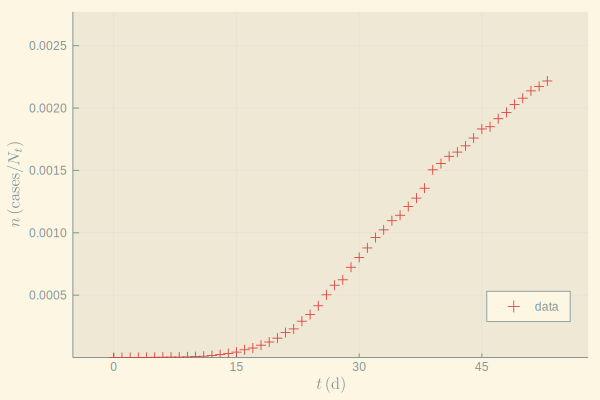

In [8]:
plot( Δtv, ndata, label="data"
    , markershape=:+, markersize=5, linealpha=0
    , legend=:bottomright )
plot!( xlabel = L"t \, \mathrm{(d)}",
    xlims = (-5,tM), xticks = 0:15:tM )
plot!( ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (nm,nM)  )

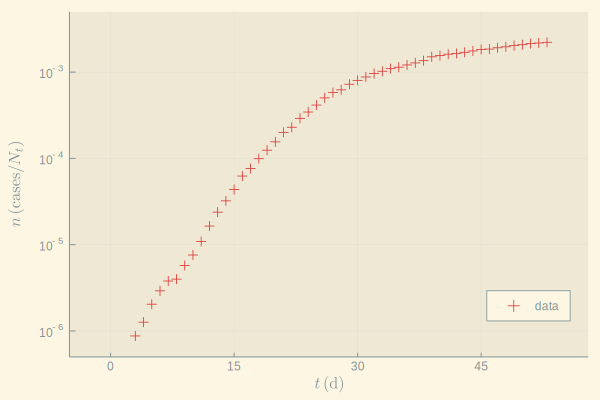

In [9]:
savefig("img/"*country_name*"_raw.svg")
plot!( yscale = :log10, ylims = (5*10^(-7.), 5*10^(-3.)) )

In [10]:
savefig("img/"*country_name*"_raw_log.svg")
plot!( yscale = :auto, ylims = (nm,nM) );

### The models
__Note:__ parameter p[2] is not multiplied by p[1] as in the main notes. Here p[2] is dimensionless! To recover the definition used in the main text divide by p[1], ie t_0 = p[2]/p[1]

In [11]:
# simple logistic model
@. model0(t,p) = 1/( 1.0 +exp( -p[1]*t +p[2] ) )

model0 (generic function with 1 method)

In [12]:
# the m-steady state model and its Jacobian
# definitions of modelm, modelm_j and all other relevant functions
# at Mrate.jl and MyFunctions.jl

function m_m( t, p )
    modelm(t,p,ρ0)
end

function j_m(t::Array,p)
    J = Array{Float64}(undef, length(t), length(p))
    J = modelm_j(t, p, ρ0)
end

j_m (generic function with 1 method)

In [13]:
p0 = [0.25, 0. ];
x0 = [0, 1.0, 2.0];
@time model0(0.0, p0);
@time model0(x0, p0);
@time m_m(0.0,p0);
@time m_m(x0,p0);
@time j_m(x0,p0);

p2 = [0.25, 18.8, 0.0025, 45., 0.035, 65. ];
@time m_m(0.0,p2);
@time m_m(x0,p2);
@time j_m(x0,p2);

  0.089301 seconds (206.31 k allocations: 11.586 MiB)
  0.212688 seconds (613.69 k allocations: 30.871 MiB, 9.30% gc time)
  0.534970 seconds (656.32 k allocations: 34.481 MiB, 3.97% gc time)
  0.112131 seconds (239.78 k allocations: 12.636 MiB)
  2.623369 seconds (4.71 M allocations: 256.072 MiB, 3.25% gc time)
  0.000008 seconds (2 allocations: 32 bytes)
  0.000008 seconds (1 allocation: 112 bytes)
  0.000015 seconds (32 allocations: 3.719 KiB)


### Nonlinear fits
#### The logistic fit

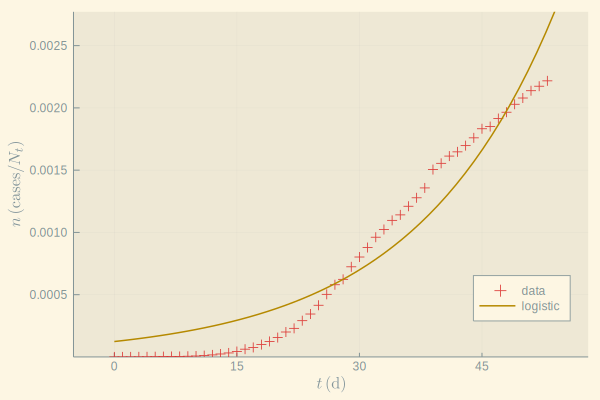

In [14]:
dm, dM = 1, length(Δtv)
fit0 = curve_fit( model0, Δtv[dm:dM], ndata[dm:dM], p0 )

tcont = range(Δtv[1],Δtv[end]*1.1; length=length(Δtv))
estimate0 = model0( tcont, fit0.param )
plot!( tcont, estimate0, label="logistic", linewidth=1.5 )

In [15]:
savefig("img/"*country_name*"_logistic.svg")


# truncate the dataset
dm, dM = 1, 25
p0 = [1., 25]

fit0b = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p0 )
estimate0b = m_m( tcont, fit0b.param );

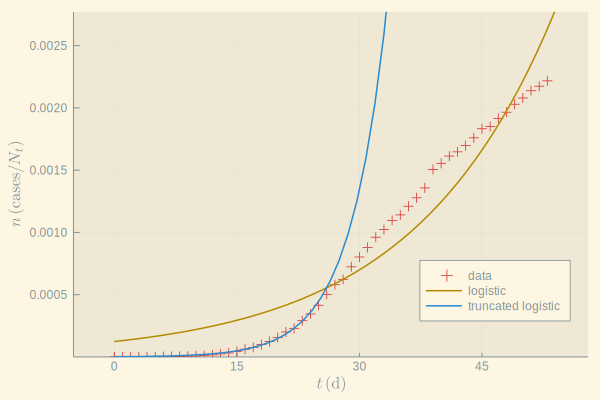

In [16]:
pstr = "truncated logistic"
plot!( tcont, estimate0b, label=pstr, linewidth = 1.5 )

In [17]:
# half-population date!
t12 = floor( fit0b.param[2]/fit0b.param[1] )
t_offset +Dates.Day( t12 )

2020-05-02

#### two steady state model m=1

In [18]:
dm, dM = 1, length(Δtv)
p1 = [0.27, 30, 0.05, 30 ]
fit1 = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p1 )
estimate1 = m_m( tcont, fit1.param );

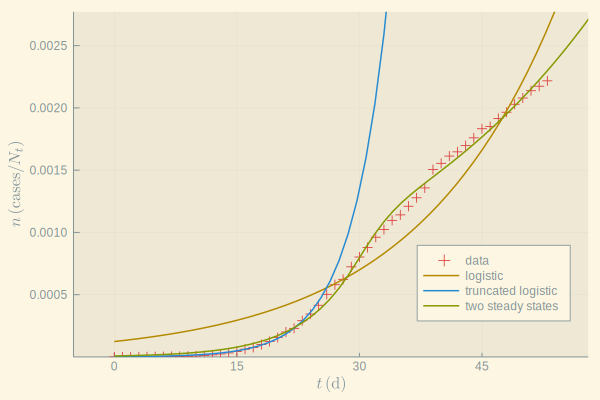

In [19]:
pstr = "two steady states"
plot!( tcont, estimate1, label=pstr, linewidth=1.5  )

In [20]:
# transition date (day)
t_offset +Dates.Day( floor( fit1.param[4] ) )

2020-03-28

#### three steady state m=2

In [21]:
dm, dM = 1, length(Δtv)
p2 = [0.27, 15, 0.01, 15, 0.005, 30 ]

fit2 = curve_fit( m_m, j_m, Δtv[dm:dM], ndata[dm:dM], p2; show_trace=true )
estimate2 = m_m( tcont, fit2.param );

     0     5.622149e-05              NaN
 * lambda: 10.0

     1     4.357409e-05     4.557215e-05
 * g(x): 4.557214688361517e-5
 * lambda: 10.0
 * dx: [0.03682750238805056, -0.34712182342594833, 0.0677056218274517, 0.08980516730829123, 0.10006222800318772, 0.0013542630570007345]

     2     2.387696e-05     1.169242e-03
 * g(x): 0.0011692424519358987
 * lambda: 1.0
 * dx: [-0.0013372053155332562, 0.028861985412678117, -0.001997697313130501, -0.1262275959152903, -0.0026079497172582264, 0.14827167323309426]

     3     7.076410e-06     2.626573e-04
 * g(x): 0.00026265728441816037
 * lambda: 0.1
 * dx: [-0.002123786818924964, 0.04555172214137787, -0.0034985440695790193, -0.19950265582817356, -0.00868215595391617, 0.24071095090349703]

     4     1.528660e-06     5.889067e-05
 * g(x): 5.8890670891208405e-5
 * lambda: 0.010000000000000002
 * dx: [0.0038325570084083247, -0.081287367187307, 0.002103710013513726, 0.3581133319405731, -0.03397742320602326, 0.1737931393195944]

     5     5.9917

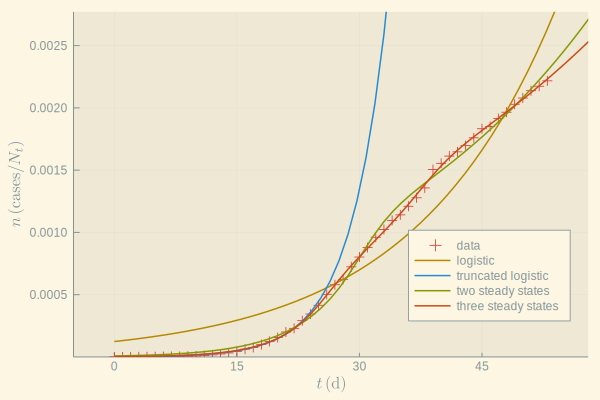

In [22]:
estimate2 = m_m( tcont, fit2.param )
pstr = "three steady states"
plot!( tcont, estimate2, label=pstr, linewidth=1.5)

In [23]:
savefig("img/"*country_name*"_fits_converged.svg")

plot!( yscale = :log10, ylims = (5*10^(-7.), 5*10^(-3.)) )
savefig("img/"*country_name*"_fits_converged_log.svg")

In [24]:
plot!( yscale = :auto, ylims = (nm,nM) )

# transition dates
t_offset +Dates.Day.( floor.( fit2.param[4:2:length(p2)] ) )

2-element Array{Date,1}:
 2020-03-23
 2020-04-06

In [25]:
# doubling times for each rate
round.( log(2) ./fit2.param[1:2:length(p2)]; sigdigits=3 )'

1×3 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 3.29  11.0  27.6

##### Estimate quality of fit

In [26]:
cov_mat = estimate_covar(fit2)
sigma = stderror(fit2)

margin_of_error = margin_error(fit2, 0.05)
confidence_inter = confidence_interval(fit2, 0.05)

# display the parameters
round.( fit2.param; sigdigits=3 )'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.21  13.0  0.0629  21.0  0.0252  34.0

In [27]:
# estimate the margins of error
round.( sigma; sigdigits=3 )'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.00829  0.193  0.00208  0.344  0.000756  0.423

In [28]:
# estimate the margins of error
round.( margin_of_error; sigdigits=3 )'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 0.0167  0.389  0.00419  0.693  0.00152  0.85

In [29]:
# estimate the margins of error
confidence_inter

6-element Array{Tuple{Float64,Float64},1}:
 (0.19379361033459663, 0.22714274954684566)
 (12.634400547811794, 13.41219267569203)
 (0.05876054463298423, 0.06713477147898615)
 (20.299005632859576, 21.68432486158318)
 (0.023638910067952774, 0.026677551184333112)
 (33.18077402732268, 34.879782100384524)

In [30]:
# the covariance matrix estimate
round.( cov_mat; sigdigits=3 )

6×6 Array{Float64,2}:
  6.88e-5    0.0016     6.04e-6   -0.00236    4.74e-7   -0.000787
  0.0016     0.0374     0.000126  -0.0516     9.81e-6   -0.0164
  6.04e-6    0.000126   4.34e-6   -0.000502   5.39e-7   -0.00074
 -0.00236   -0.0516    -0.000502   0.119     -4.44e-5    0.07
  4.74e-7    9.81e-6    5.39e-7   -4.44e-5    5.71e-7   -0.000222
 -0.000787  -0.0164    -0.00074    0.07      -0.000222   0.179